In [176]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline
plt.style.use('seaborn-darkgrid')
plt.rcParams['figure.figsize'] = (16, 9)

In [177]:
import fair
from matplotlib import pyplot as plt
import fair.forward

In [178]:
# import historical observations

Historical_obs = pd.read_csv("/Users/michelledvorak/Documents/2020 RA'ship/Historical_Observations.csv")

In [179]:
Historical_obs['Volcanic forcing'] = Historical_obs['Volcanic forcing '] # lazy way to correct extra space

In [180]:
Historical_obs['Total natural forcing'] = Historical_obs['Volcanic forcing'] + Historical_obs['Solar forcing']

In [181]:
F_historical = np.array(Historical_obs['Total (manmade+solar+volcano) forcing'])

In [182]:
F_natural = np.array(Historical_obs['Total natural forcing'])

In [183]:
T_observed = np.array(Historical_obs['Observed Temperature'])

In [184]:
# define set parameters

# lam = 1.2 , climate sensitivity parameter, watts/m2/k
lam = 1.35 # climate sensitivity parameter for ECS = 2.75 (FaIR)
d_deep = 1100  # depth of deep ocean, m
d_ml = 70  # depth of mixed layer, m
gam = 0.963  # coupling parameter, watts/m2/k
eps = 1.0 # efficacy factor; see Geoffrey et al. 2013 Part II for values tuned to GCM's

rho = 1025  # density of seawater, kg/m3
cp = 3985 # specific heat capacity of seawater, J/kg/C
# f0 = 0.7 # percentage of Earth's surface covered by ocean
alpha = 2500*1e-7  # thermal expansion coefficient
dt = 30.25*24*60*60*12  # time-step (one year in seconds)
Cml = (1025*3985*70)
Cdeep = (1025*3985*1100)

135


In [185]:
# define the model

def two_layer_model(t0, tdeep0, lam, eps, gam, f, Cml, Cdeep, dt, Year0):
        
    t = t0 + ((-lam*t0 - eps*gam*(t0 - tdeep0)) + f)*dt/Cml
    tdeep = tdeep0 + gam*(t0 - tdeep0)*dt/Cdeep
    sealevel = t0*d_ml*alpha + tdeep0*d_deep*alpha
    toa_imbalance = f - lam*t0 
    Year = Year0 + 1
    
    return t, tdeep, sealevel, toa_imbalance

    print(Year)
    
def forc_to_temp(lam, eps, gam, f, Cml, Cdeep, dt):        
    
    nt = len(f)
    Year = np.zeros(nt + 1)
    Year = Year.astype(int)
    Year[0] = 1880

    Tml = np.zeros(nt)
    Tdeep = np.zeros(nt)
    sealevel = np.zeros(nt)
    toa_imbalance = np.zeros(nt)
    Tml[0] = 0 # Temperature of mixed layer, initial
    Tdeep[0] = 0 # Temperature of deep ocean, initial
        
    for t in range(1,nt):
        Tml[t], Tdeep[t], sealevel[t], toa_imbalance[t] = two_layer_model(Tml[t-1], Tdeep[t-1], 
                                                                          lam, eps, gam, f[t], 
                                                                          Cml, Cdeep, dt, Year)
    return Tml, Tdeep, sealevel, toa_imbalance

In [186]:
# run the model

T_historical, Tdeep_historical, _, _ = forc_to_temp(lam, eps, gam, F_historical, Cml, Cdeep, dt)

In [187]:
T_natural, Tdeep_natural, _, _ = forc_to_temp(lam, eps, gam, F_natural, Cml, Cdeep, dt)

In [188]:
# let's examine the same historical forcing in FaIR

_, F_hist, T_hist = fair.forward.fair_scm(emissions=False, other_rf = F, useMultigas=False)

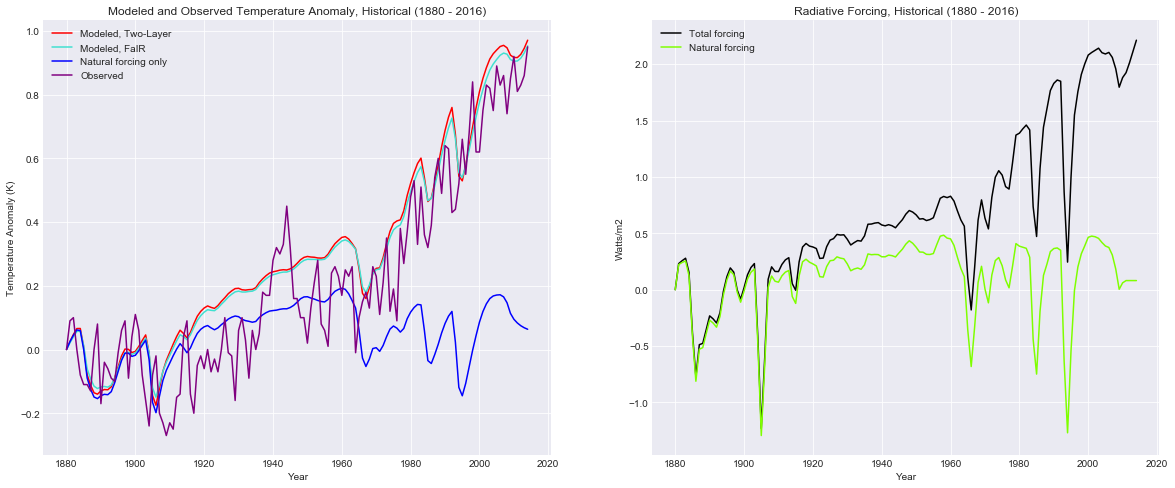

In [189]:
plt.figure(figsize=(20,8))
plt.subplot(121)
plt.plot(range(1880,2015), T_historical, color='red', label = 'Modeled, Two-Layer')
plt.plot(range(1880,2015), T_hist, color = 'turquoise', label = 'Modeled, FaIR')
# plt.plot(Tdeep, color = 'blue', label = 'Deep Ocean')
plt.plot(range(1880,2015), T_natural, color = 'blue', label = 'Natural forcing only')
plt.plot(range(1880,2015), T_observed, color = 'purple', label = 'Observed')
plt.title('Modeled and Observed Temperature Anomaly, Historical (1880 - 2016)')
plt.xlabel('Year')
plt.ylabel('Temperature Anomaly (K)')
plt.legend()


plt.subplot(122)
plt.plot(range(1880,2015), F, color = 'black', label = 'Total forcing')
plt.plot(range(1880,2015), F_natural, color = 'chartreuse', label = 'Natural forcing')
plt.xlabel('Year')
plt.ylabel('Watts/m2')
plt.title('Radiative Forcing, Historical (1880 - 2016)')
plt.legend()

In [190]:
# predict future temperature change

# RCP4.5, 8.5

Future_scenarios = pd.read_csv("/Users/michelledvorak/Documents/2020 RA'ship/Forcing scenarios.csv")

In [192]:
F_26 = np.array(Future_scenarios['Total forcing 2.6'])
F_45 = np.array(Future_scenarios['Total forcing 4.5'])
F_60 = np.array(Future_scenarios['Total forcing 6.0'])
F_85 = np.array(Future_scenarios['Total forcing 8.5'])

from fair.RCPs import rcp3pd, rcp45, rcp6, rcp85


In [193]:
# run the model using parameters 1) tuned for accordance with FaIR and 
# 2) adjusted for efficacy factor according to Geoffrey et al. 2013 part 2 (multimodel means)

TML_26, TDEEP_26, _, N_26 = forc_to_temp(lam, eps, gam, F_26, Cml, Cdeep, dt)
TML_45, TDEEP_45, _, N_45 = forc_to_temp(lam, eps, gam, F_45, Cml, Cdeep, dt)
TML_60, TDEEP_60, _, N_60 = forc_to_temp(lam, eps, gam, F_60, Cml, Cdeep, dt)
TML_85, TDEEP_85, _, N_85 = forc_to_temp(lam, eps, gam, F_85, Cml, Cdeep, dt)


TML_26_v2, _, _, N_26_v2 = forc_to_temp(lam, eps=1.28, gam=0.67, f=F_26, Cml=Cml, Cdeep=Cdeep, dt=dt)
TML_45_v2, _, _, N_45_v2 = forc_to_temp(lam, eps=1.28, gam=0.67, f=F_45, Cml=Cml, Cdeep=Cdeep, dt=dt)
TML_60_v2, _, _, N_60_v2 = forc_to_temp(lam, eps=1.28, gam=0.67, f=F_60, Cml=Cml, Cdeep=Cdeep, dt=dt)
TML_85_v2, _, _, N_85_v2 = forc_to_temp(lam, eps=1.28, gam=0.67, f=F_85, Cml=Cml, Cdeep=Cdeep, dt=dt)


No handles with labels found to put in legend.


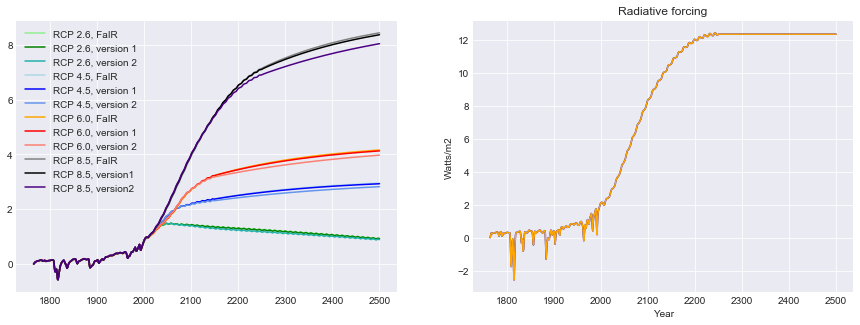

In [197]:
# run the FaIR model with same radiative forcing, emissions off, for RCP 4.5 and 8.5:

_, F26, T26 = fair.forward.fair_scm(emissions=False, other_rf = F_26, useMultigas=False)
_, F45, T45 = fair.forward.fair_scm(emissions=False, other_rf = F_45, useMultigas=False)
_, F60, T60 = fair.forward.fair_scm(emissions=False, other_rf = F_60, useMultigas=False)
_, F85, T85 = fair.forward.fair_scm(emissions=False, other_rf = F_85, useMultigas=False)
plt.figure(figsize=(15,5))

# plot output alongside two-layer model projections

plt.subplot(121)
# plt.plot(Tdeep, color = 'blue', label = 'Deep Ocean')
plt.plot(range(1765,2501), T26, color = 'lightgreen', label = 'RCP 2.6, FaIR')
plt.plot(range(1765,2501), TML_26, color='green', label = 'RCP 2.6, version 1')
plt.plot(range(1765,2501), TML_26_v2, color='lightseagreen', label = 'RCP 2.6, version 2')

plt.plot(range(1765,2501), T45, color = 'lightblue', label = 'RCP 4.5, FaIR')
plt.plot(range(1765,2501), TML_45, color='blue', label = 'RCP 4.5, version 1')
plt.plot(range(1765,2501), TML_45_v2, color='cornflowerblue', label = 'RCP 4.5, version 2')

plt.plot(range(1765,2501), T60, color = 'orange', label = 'RCP 6.0, FaIR')
plt.plot(range(1765,2501), TML_60, color='red', label = 'RCP 6.0, version 1')
plt.plot(range(1765,2501), TML_60_v2, color='salmon', label = 'RCP 6.0, version 2')

plt.plot(range(1765,2501), T85, color = 'grey', label = 'RCP 8.5, FaIR')
plt.plot(range(1765,2501), TML_85, color='black', label = 'RCP 8.5, version1')
plt.plot(range(1765,2501), TML_85_v2, color='indigo', label = 'RCP 8.5, version2')
plt.legend()

# plt.plot(Tdeep, color = 'blue', label = 'Deep Ocean')

plt.subplot(122)
plt.plot(range(1765,2501), F85, color = 'blue')
plt.plot(range(1765,2501), F_85, color = 'orange')

plt.title('Radiative forcing')
plt.xlabel('Year')
plt.ylabel('Watts/m2')
plt.legend()